# 7.3. 网络中的网络（NiN）

LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。 AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块。 或者，可以想象在这个过程的早期使用全连接层。然而，如果使用了全连接层，可能会完全放弃表征的空间结构。 网络中的网络（NiN）提供了一个非常简单的解决方案：在每个像素的通道上分别使用多层感知机

 NiN的想法是在每个像素位置（针对每个高度和宽度）应用一个全连接层。 如果我们将权重连接到每个空间位置，我们可以将其视为1X1卷积层（如 6.4节中所述），或作为在每个像素位置上独立作用的全连接层。 从另一个角度看，即将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature）。

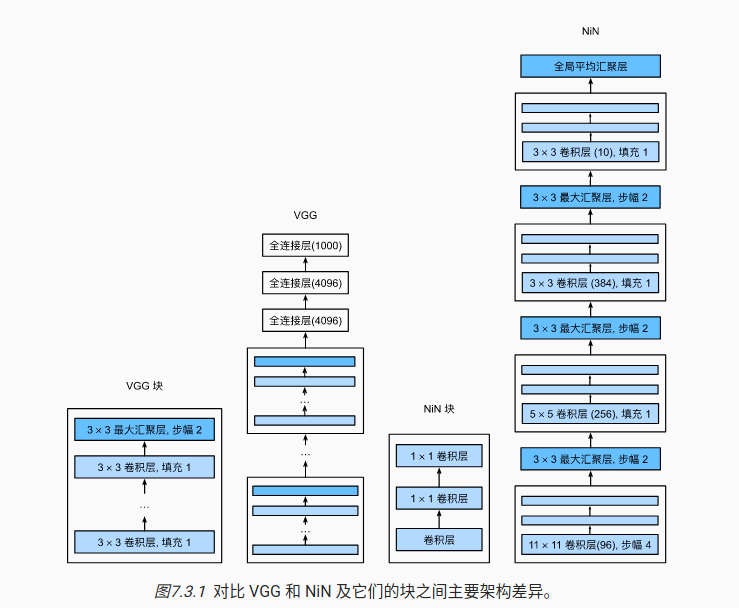

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 7.3.1. NiN块

In [2]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )

# 7.3.2. NiN模型

最初的NiN网络是在AlexNet后不久提出的，显然从中得到了一些启示。 NiN使用窗口形状为11X11、5X5和3X3的卷积层，输出通道数量与AlexNet中的相同。 每个NiN块后有一个最大汇聚层，汇聚窗口形状为3X3，步幅为2。

NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层。 相反，NiN使用一个NiN块，其输出通道数等于标签类别的数量。最后放一个全局平均汇聚层（global average pooling layer），生成一个对数几率 （logits）。NiN设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模型的时间。

In [3]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten()
)

In [4]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


# 7.3.3. 训练模型


loss 2.303, train acc 0.100, test acc 0.100
247.7 examples/sec on cuda:0


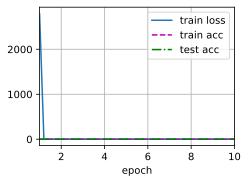

In [5]:
lr, num_epochs, batch_size = 0.1, 10, 8
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.3.4. 小结

NiN使用由一个卷积层和多个1X1卷积层组成的块。该块可以在卷积神经网络中使用，以允许更多的每像素非线性。

NiN去除了容易造成过拟合的全连接层，将它们替换为全局平均汇聚层（即在所有位置上进行求和）。该汇聚层通道数量为所需的输出数量（例如，Fashion-MNIST的输出为10）。

移除全连接层可减少过拟合，同时显著减少NiN的参数。

NiN的设计影响了许多后续卷积神经网络的设计。

# 7.3.5. 练习